In [1]:
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
import statsmodels.api as sm
import pandas as pd
import numpy as np
import yfinance as yf
import MetaTrader5 as mt5
import datetime as dt
import ta
import pytz
from statsmodels.regression.rolling import RollingOLS
import numpy as np
from scipy.optimize import minimize
import pickle
from sklearn.cluster import KMeans
timezone = pytz.timezone("Etc/UTC")
timezone
today = dt.datetime.now()

c:\Users\camps pro\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
def padrao(df):
    df.rename(columns={'time':'Date', 'open':'Open', 'high':'High','low':'Low','close':'Close'}, inplace=True)
    df.drop(['tick_volume','spread','real_volume'], axis=1, inplace=True)
    df.set_index('Date', inplace=True)
    return df

def retorno(df):
    df['Retorno'] = df['Close'].pct_change()
    
    df.dropna(inplace=True)
    return df

In [3]:
def var(df):
    

    

    


    df['RSL5'] = (df['Close']/df['Close'].rolling(5).mean())-1
    df['RSL5q'] = pd.qcut(df['RSL5'], q=7, labels=False)
    df['RSL20'] = (df['Close']/df['Close'].rolling(20).mean())-1

    df['delta'] = df['Close'].diff()
    df['gain'] = np.where(df['delta']>=0, df['delta'], 0)
    df['loss'] = np.where(df['delta']<0, abs(df['delta']), 0)
    avg_gain = df['gain'].rolling(window=5).mean()
    avg_loss = df['loss'].rolling(window=5).mean()
    rs = avg_gain / avg_loss
    df['rsi'] = 100 - (100 / (1 + rs))
    df['rsi_cat'] = pd.qcut(df['rsi'], 7,labels=False)

    df['filtro'] = np.where(df["RSL5"] < df["RSL20"], 1, -1) 
    df['media_movel'] = df['Close'].rolling(200).mean()
    df['media_movel2'] = df['Close'].rolling(5).mean()
    h = df['media_movel2'] / df['media_movel']
    l = 3 
    df['tan200'] = h/l
    df['ang200'] = np.degrees(df['tan200'])
    df['ang_cat'] = pd.qcut(df['ang200'], q=5, labels=False)

    df['sinal'] = np.where((df['filtro']==-1)& ((df['ang_cat'] ==0) | df['ang_cat'] ==2), -1,
                            np.where((df['filtro']==1)& ((df['ang_cat'] ==5) | df['ang_cat'] ==3), 1, 0)) 

    df['rsi_sinal'] = np.where(df['rsi'] < 30, 1,
                          np.where(df['rsi'] > 70, -1, 0))


    df['rsi_cat_sinal'] = np.where((df['rsi_sinal'] == 1) & ((df['rsi_cat'] == 4)| (df['rsi_cat'] == 6)| (df['rsi_cat'] == 1)),1,
                            np.where((df['rsi_sinal'] == -1) & ((df['rsi_cat'] == 2)| (df['rsi_cat'] == 5)), -1, 0))


    df['desvio_padrao'] = df["Retorno"].rolling(window=15).std()
    df['media'] = df["Retorno"].rolling(window=15).mean()
    df['ajuste_media'] = df["Retorno"] - df['media']
    df['max_diff'] = df['ajuste_media'].rolling(window=15).max()
    df['min_diff'] = df['ajuste_media'].rolling(window=15).min()
    df['R/S'] = (df['max_diff'] - df['min_diff'])/df['desvio_padrao']
    df['hurst'] = (np.log2(df['R/S'].values))/np.log2(15)

    df['hurst_sinal'] = np.where(df['hurst'] > 0.5, 1, np.where(df['hurst'] < 0.45, -1, 0))

    df['std15'] = df['Close'].rolling(15).std()
    df['MA'] = df['Close'].rolling(5).mean()

    df["zscore"] = ((df["Close"]-df['Close'].rolling(5).mean())/df['Close'].rolling(10).std())
    std = (df['zscore'].std())*1.2
    df['zscore_sinal'] = np.where(df['zscore'] > std, -1, np.where(df['zscore'] < -std, 1, 0))


    df['delta'] = df['Close'].diff()
    df['gain'] = np.where(df['delta']>=0, df['delta'], 0)
    df['loss'] = np.where(df['delta']<0, abs(df['delta']), 0)
    avg_gain = df['gain'].rolling(window=5).mean()
    avg_loss = df['loss'].rolling(window=5).mean()
    rs = avg_gain / avg_loss
    df['rsi'] = 100 - (100 / (1 + rs))
    #df['rsi'] = pd.qcut(df['rsi'], 5,labels=False)





    stochasticOscillator = ta.momentum.StochasticOscillator(high=df['High'], low=df['Low'], close=df['Close'], window=15, smooth_window=3)
    df['stochasticOscillator'] = stochasticOscillator.stoch()
    df['stochasticOscillator'] = df['stochasticOscillator']/100
    #df['stochasticOscillator'] = pd.qcut(df['stochasticOscillator'], 5, labels=False)

    df['stochasticOscillator_sinal'] = np.where(df['stochasticOscillator'] <= 0.2, 1, np.where(df['stochasticOscillator'] < 0.8, -1, 0))



    #bandas de bollingerBand
    bollingerBand = ta.volatility.BollingerBands(close=df['Close'], window=20, window_dev=2)
    df['bb_bollinger_avg'] = bollingerBand.bollinger_mavg()
    df['bb_lband'] = bollingerBand.bollinger_lband()
    df['bb_hband'] = bollingerBand.bollinger_hband()
    df['sinal_bb'] = np.where(df['Close']>df['bb_hband'],-1, np.where(df['Close']<df['bb_lband'],1,0))


    
    h = df['Close'].shift(21) - df['Close']
    l = 21
    df['tan30'] = h/l
    df['ang30'] = np.arctan(df['tan30'])
    std = (df['ang30'].std())
    df['tan30_sinal'] = np.where(df['ang30'] > std, 1, np.where(df['ang30'] < -std, -1, 0))
    df['tan30_cat'] = pd.qcut(df['ang30'], q=4, labels=[1,2,3,4])




    stochRSI = ta.momentum.StochRSIIndicator(close=df['Close'], window=15, smooth1=3, smooth2=3)
    df['stochRSI'] = stochRSI.stochrsi()
    df['stochRSI_cat'] = pd.qcut(df['stochRSI'], 5, labels=False)

    df['stochRSI_sinal'] = np.where((df['tan30_cat'] == 1) & (df['stochRSI_cat'] == 0), 1,
                                np.where((df['tan30_cat'] == 2) & (df['stochRSI_cat'] == 4), -1, 0))



    vol_p1 = 20
    df['Vol'] = np.round(df['Retorno'].rolling(vol_p1).std()*np.sqrt(252), 4)

    df["Date"] = df.index
    df["WeekDay"] = df["Date"].dt.dayofweek #Monday is day 0


    WeeklyVol = df["Vol"]/np.sqrt(52)
    RefPrice = df["Close"]
    df["WeeklyVol"] = df["Vol"]/np.sqrt(52)
    df["RefPrice"] = df["Close"]

    for i in range(1,len(df)):
        if df["WeekDay"][i] == 0:
            df["WeeklyVol"][i] = WeeklyVol[i-1]
            df["RefPrice"][i] = RefPrice[i-1]
        else:
            df["WeeklyVol"][i] = df["WeeklyVol"][i-1]
            df["RefPrice"][i] = df["RefPrice"][i-1]

    df["Supply_Band_1d"] = np.round(df["WeeklyVol"]*df["RefPrice"] + df["RefPrice"], 2)
    df["Demand_Band_1d"] = np.round(df["RefPrice"] - df["WeeklyVol"]*df["RefPrice"], 2)
    df["Supply_Band_2d"] = np.round(2*df["WeeklyVol"]*df["RefPrice"] + df["RefPrice"], 2)
    df["Demand_Band_2d"] = np.round(df["RefPrice"] - 2*df["WeeklyVol"]*df["RefPrice"], 2)


    df['macd_9'] = df['Retorno'].rolling(window=10).mean()
    df['macd_26'] = df['Retorno'].ewm(span=30, adjust=False).mean()
    df['disc_macs'] = (df['macd_9'] - df['macd_26'])-1
    df['disc_macs'] = pd.qcut(df['disc_macs'], 10, labels=False)

    df["dis_vol"] = df["Vol"]/df["WeeklyVol"]
    df["dis_vol_cat"] = pd.qcut(df["dis_vol"], 7, labels=False)

    df['Return20'] = df['Close'].pct_change(20)
    df['sum_returns']=df['Return20'].rolling(5).mean()
    df['return_cost'] = df['Return20']/df['sum_returns']
    df['return_cost_cat'] = pd.qcut(df['return_cost'], 7, labels=False)


    df['MA20'] = df['Close'].rolling(20).mean()
    #df['Return20'] = df['Return20'].shift(-20)
    df['STD_Returns'] = df['Return20'].rolling(20).std()
    df['RSL20'] = (df['Close']/df['MA20'])-1
    df['RSL'] = (df['Close']/df['Close'].rolling(10).mean())-1

    df['delta1'] = df['Close'].diff()
    df['gain1'] = np.where(df['delta1']>=0, df['delta1'], 0)
    df['loss1'] = np.where(df['delta1']<0, abs(df['delta1']), 0)
    avg_gain1 = df['gain1'].rolling(window=20).mean()
    avg_loss1 = df['loss1'].rolling(window=20).mean()
    rs1 = avg_gain1 / avg_loss1
    df['rsi1'] = 100 - (100 / (1 + rs1))




    last_friday_return = 0

    df["FRI_Returns"] = None

    # Iterate through df1
    for idx, row in df.iterrows():
        # Check if the day is Friday (weekday() returns 4 for Friday)
        if idx.weekday() == 4:
            last_friday_return = row["Return20"]
        
        df.at[idx, "FRI_Returns"] = last_friday_return

    # Initialize a variable to store the last Friday STD_Returns
    last_STD_Returns = 0

    # Create a new column for the Friday STD_Returns in df1
    df["FRI_STD_Returns"] = None

    # Iterate through df1
    for idx, row in df.iterrows():
        # Check if the day is Friday (weekday() returns 4 for Friday)
        if idx.weekday() == 4:
            last_STD_Returns = row["STD_Returns"]
        
        df.at[idx, "FRI_STD_Returns"] = last_STD_Returns


    # Initialize a variable to store the last Friday RSL
    last_RSL = 0

    # Create a new column for the Friday RSL in df1
    df["FRI_RSL"] = None

    # Iterate through df1
    for idx, row in df.iterrows():
        # Check if the day is Friday (weekday() returns 4 for Friday)
        if idx.weekday() == 4:
            last_RSL = row["RSL20"]
        
        df.at[idx, "FRI_RSL"] = last_RSL

    last_rsi = 0
    df['FRI_rsi'] = None
    for idx, row in df.iterrows():
        if idx.weekday() == 4:
            last_friday_rsi = row['rsi1']

        df.at[idx, "FRI_rsi"] = last_rsi

    df.dropna(axis = 0, inplace = True) 
    #Distância do cosseno
    # Initialize a list to store the results for each row
    COS_DIST = []

    # Iterate over each row in the DataFrame
    for index, row in df.iterrows():
        # Extract the values for each set of columns for this row
        array1 = row[["FRI_Returns", "FRI_STD_Returns", "FRI_RSL"]].to_numpy()
        array2 = row[["Return20", "STD_Returns", "RSL"]].to_numpy()

        # Dot product of the two arrays
        dot_product = np.dot(array1, array2)

        # Sum of squares of each array and then square root
        sqrt_sum_squares_array1 = np.sqrt(np.sum(np.square(array1)))
        sqrt_sum_squares_array2 = np.sqrt(np.sum(np.square(array2)))

        # Calculate the result for this row and append it to the results list
        row_result = dot_product / (sqrt_sum_squares_array1 + sqrt_sum_squares_array2)
        COS_DIST.append(row_result)

    # Add the results as a new column to df1
    df["COS_DIST"] = COS_DIST
    df['COS_DIST_cat'] = pd.qcut(df['COS_DIST'], 7, labels=False)


    # Iterate over each row in the DataFrame

    COS_DIST2 = []
    for index, row in df.iterrows():
        # Extract the values for each set of columns for this row
        array1 = row[["FRI_Returns", "FRI_STD_Returns", "FRI_RSL",'FRI_rsi']].to_numpy()
        array2 = row[["Return20", "STD_Returns", "RSL",'rsi1']].to_numpy()

        # Dot product of the two arrays
        dot_product = np.dot(array1, array2)

        # Sum of squares of each array and then square root
        sqrt_sum_squares_array1 = np.sqrt(np.sum(np.square(array1)))
        sqrt_sum_squares_array2 = np.sqrt(np.sum(np.square(array2)))

        # Calculate the result for this row and append it to the results list
        row_result = dot_product / (sqrt_sum_squares_array1 + sqrt_sum_squares_array2)
        COS_DIST2.append(row_result)

    # Add the results as a new column to df1
    df["COS_DIST2"] = COS_DIST2
    df['COS_DIST2_cat'] = pd.qcut(df['COS_DIST2'], 7, labels=False)





    # Initialize a list to store the Euclidean distances for each row
    euclidean_distances = []

    # Iterate over each row in the DataFrame
    for index, row in df.iterrows():
        # Extract the values for each set of columns for this row
        array1 = row[["FRI_Returns", "FRI_STD_Returns", "FRI_RSL"]].to_numpy()
        array2 = row[["Return20", "STD_Returns", "RSL"]].to_numpy()

        # Calculate Euclidean distance
        distance = np.linalg.norm(array1 - array2)

        # Append the calculated distance to the list
        euclidean_distances.append(distance)

    # Add the Euclidean distances as a new column to df1
    df["EUC_DIST"] = euclidean_distances
    df['EUC_DIST_cat'] = pd.qcut(df['EUC_DIST'], 7, labels=False)

    euclidean_distances2 = []

    # Iterate over each row in the DataFrame
    for index, row in df.iterrows():
        # Extract the values for each set of columns for this row
        array1 = row[["FRI_Returns", "FRI_STD_Returns", "FRI_RSL",'FRI_rsi']].to_numpy()
        array2 = row[["Return20", "STD_Returns", "RSL",'rsi1']].to_numpy()

        # Calculate Euclidean distance
        distance = np.linalg.norm(array1 - array2)

        # Append the calculated distance to the list
        euclidean_distances2.append(distance)

    # Add the Euclidean distances as a new column to df1
    df["EUC_DIST2"] = euclidean_distances2
    df['EUC_DIST2_cat'] = pd.qcut(df['EUC_DIST2'], 7, labels=False)


    df['curva_rsl'] = np.where(df['FRI_RSL'] == df['RSL20'], 0, 
                            np.where(df['FRI_RSL'] > df['RSL20'], 1, -1))

    df['curva_std'] = np.where(df['FRI_STD_Returns'] == df['STD_Returns'], 0, 
                            np.where(df['FRI_STD_Returns'] > df['STD_Returns'], 1, -1))


    df['dis_rsl'] = df['RSL20']/df['FRI_RSL']

    df['dis_std'] = df['STD_Returns']/df['FRI_STD_Returns']


    df['dis_euc_sinal'] = np.where(((g['EUC_DIST2_cat']== 0) & (g['EUC_DIST_cat']== 3)), 1,
                                np.where(((df['EUC_DIST_cat']== 5) | (df['EUC_DIST_cat']== 6)) & ((df['EUC_DIST2_cat']== 4) | (df['EUC_DIST2_cat']== 5)), -1, 0))

    df['dis_cos_sinal'] = np.where(((g['COS_DIST_cat']== 2) | (g['COS_DIST_cat']== 6)) & (g['COS_DIST2_cat']== 2), 1,
                                np.where(((df['COS_DIST_cat']== 1) | (df['COS_DIST_cat']== 4)) & ((df['COS_DIST2_cat']== 1) | (df['COS_DIST2_cat']== 0)), -1, 0))

    df['RSL20_cat'] = pd.qcut(df['RSL20'], 7, labels=False)


    df['Price_Lag'] = df['Close'].shift(1)
    df['Price_Lag2'] = df['Close'].shift(2)

    # Adicione a constante ao DataFrame
    df["const"] = 1

    # Ajuste o modelo de regressão com as novas colunas
    rolling_reg = RollingOLS(endog=df["Close"], exog=df[["const", "Price_Lag", "Price_Lag2"]], window=252)
    reg = rolling_reg.fit()

    # Extraia os coeficientes do modelo
    df['beta0'] = reg.params['const']
    df['beta1'] = reg.params['Price_Lag']
    df['beta2'] = reg.params['Price_Lag2']

    # Calcule a regressão
    df['reg'] = df['beta0'] + df['beta1'] * df['Price_Lag'] + df['beta2'] * df['Price_Lag2']
    df['detrend_reg'] = df['Close'] - df['reg']

    df['MM20'] = df['Close'].rolling(20).mean()

    df['index'] = np.arange(len(df))

    df['curva1_a'] = 1
    df['curva1_b'] = 1
    df['curva1_c'] = 1
    df['curva1_d'] = 1

    df['curva2_a'] = 1
    df['curva2_b'] = 2
    df['curva2_c'] = 1
    df['curva2_d'] = 1

    df['curva3_a'] = 1
    df['curva3_b'] = 3
    df['curva3_c'] = 1
    df['curva3_d'] = 1

    df['curva1'] = df['curva1_a'] * np.sin(df['curva1_b'] * df['index'] + df['curva1_c']) + df['curva1_d']
    df['curva2'] = df['curva2_a'] * np.sin(df['curva2_b'] * df['index'] + df['curva2_c']) + df['curva2_d']
    df['curva3'] = df['curva3_a'] * np.sin(df['curva3_b'] * df['index'] + df['curva3_c']) + df['curva3_d']


    df['curva_final'] = df['curva1'] + df['curva2'] + df['curva3']

    df['erro'] = df['detrend_reg'] - df['curva_final']



    # Função para calcular o erro total
    def erro_total(params, df):
        a1, b1, c1, d1, a2, b2, c2, d2, a3, b3, c3, d3 = params
        
        curva1 = a1 * np.sin(b1 * df['index'] + c1) + d1
        curva2 = a2 * np.sin(b2 * df['index'] + c2) + d2
        curva3 = a3 * np.sin(b3 * df['index'] + c3) + d3
        
        curva_final = curva1 + curva2 + curva3
        erro = df['detrend_reg'] - curva_final
        return np.sum(erro**2)

    # Estimativa inicial dos parâmetros
    initial_guess = [1, 1, 1, 1, 1, 2, 1, 1, 1, 3, 1, 1]

    # Minimizar o erro para encontrar os melhores parâmetros
    result = minimize(erro_total, initial_guess, args=(df,), method='Nelder-Mead')

    # Extrair os melhores parâmetros encontrados
    a1, b1, c1, d1, a2, b2, c2, d2, a3, b3, c3, d3 = result.x
    print("Melhores parâmetros para a Curva 1:", a1, b1, c1, d1)
    print("Melhores parâmetros para a Curva 2:", a2, b2, c2, d2)
    print("Melhores parâmetros para a Curva 3:", a3, b3, c3, d3)

    # Calcular as curvas com os melhores parâmetros
    df['curva1_otimizada'] = a1 * np.sin(b1 * df['index'] + c1) + d1
    df['curva2_otimizada'] = a2 * np.sin(b2 * df['index'] + c2) + d2
    df['curva3_otimizada'] = a3 * np.sin(b3 * df['index'] + c3) + d3

    # Calcular a curva final otimizada
    df['curva_final_otimizada'] = df['curva1_otimizada'] + df['curva2_otimizada'] + df['curva3_otimizada']

    #categorizar as curvas
    df['curva_final_cat'] = pd.qcut(df['curva_final_otimizada'], 15, labels=False)
    df['curva1_cat'] = pd.qcut(df['curva1_otimizada'], 15, labels=False)
    df['curva2_cat'] = pd.qcut(df['curva2_otimizada'], 15, labels=False)
    df['curva3_cat'] = pd.qcut(df['curva3_otimizada'], 15, labels=False)
    
    df.dropna(inplace=True)
    k_var = ['curva_final_otimizada','curva1_otimizada','curva2_otimizada','curva3_otimizada','detrend_reg']

    filename = 'kmeans_curvas.sav'
    loaded_model = pickle.load(open(filename, 'rb'))

    df['cluster_curvas'] = loaded_model.predict(df[k_var])
    #salvar o modelo


    k2_var = ['RSL5', 'RSL5q', 'RSL20','RSL20_cat', 'delta', 'gain', 'loss', 'rsi', 'rsi_cat', 'filtro', 'media_movel',
       'media_movel2', 'tan200', 'ang200', 'ang_cat', 'sinal', 'rsi_sinal', 'rsi_cat_sinal', 'desvio_padrao',
       'media', 'ajuste_media', 'max_diff', 'min_diff', 'R/S', 'hurst', 'hurst_sinal', 'std15', 'MA', 'zscore',
       'zscore_sinal', 'stochasticOscillator', 'stochasticOscillator_sinal', 'bb_bollinger_avg', 'bb_lband',
       'bb_hband', 'sinal_bb', 'tan30', 'ang30', 'tan30_sinal', 'tan30_cat', 'stochRSI', 'stochRSI_cat',
       'stochRSI_sinal', 'Vol', 'WeeklyVol', 'RefPrice', 'Supply_Band_1d', 'Demand_Band_1d', 'Supply_Band_2d',
       'Demand_Band_2d', 'macd_9', 'macd_26', 'disc_macs', 'dis_vol', 'dis_vol_cat', 'Return20', 'sum_returns',
       'return_cost', 'return_cost_cat', 'MA20', 'STD_Returns', 'RSL', 'delta1', 'gain1', 'loss1', 'rsi1',
       'FRI_Returns', 'FRI_STD_Returns', 'FRI_RSL', 'FRI_rsi', 'COS_DIST', 'COS_DIST_cat', 'COS_DIST2',
       'COS_DIST2_cat', 'EUC_DIST', 'EUC_DIST_cat', 'EUC_DIST2', 'EUC_DIST2_cat', 'curva_rsl', 'curva_std',
       'dis_rsl', 'dis_std', 'dis_euc_sinal', 'dis_cos_sinal', 'RSL20_cat', 'detrend_reg', 'curva1_otimizada', 'curva2_otimizada',
       'curva3_otimizada', 'curva_final_otimizada','cluster_curvas','curva_final_cat','curva1_cat','curva2_cat','curva3_cat']

    filename = 'kmeans.sav'
    loaded_model = pickle.load(open(filename, 'rb'))

    df['cluster'] = loaded_model.predict(df[k2_var])
    
    lista = ['rsi', 'filtro','media_movel2','tan200','ang200','ang_cat','sinal','media','MA','zscore_sinal','bb_lband','bb_hband','sinal_bb','tan30','ang30','tan30_sinal','stochRSI_cat','stochRSI_sinal','RefPrice',
       'Supply_Band_1d','Supply_Band_2d','Demand_Band_2d','dis_vol','dis_vol_cat','return_cost_cat','FRI_Returns','FRI_RSL','FRI_rsi','COS_DIST2','COS_DIST2_cat','EUC_DIST','curva_rsl',
       'dis_euc_sinal','dis_cos_sinal','cluster','curva2_otimizada','curva3_cat']
    
    filename = 'modelo_mlp1_aud.sav'
    loaded_model = pickle.load(open(filename, 'rb'))

    df['rede'] = loaded_model.predict(df[lista])
        
    return df


In [4]:
ativos = ["EURUSD"]
ativo = ativos[0]
mt5.initialize()

g = mt5.copy_rates_from(ativo, mt5.TIMEFRAME_D1, today, 2000)
g = pd.DataFrame(g)
g['time'] = pd.to_datetime(g['time'], unit='s')
padrao(g)
retorno(g)
var(g)

C:\Users\camps pro\AppData\Local\Temp\ipykernel_26520\45463285.py:124: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if df["WeekDay"][i] == 0:
C:\Users\camps pro\AppData\Local\Temp\ipykernel_26520\45463285.py:128: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df["WeeklyVol"][i] = df["WeeklyVol"][i-1]
C:\Users\camps pro\AppData\Local\Temp\ipykernel_26520\45463285.py:128: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) 

Melhores parâmetros para a Curva 1: 0.00013661104768468825 1.7730661205717309 2.865671338829199 -0.29786512557417133
Melhores parâmetros para a Curva 2: 0.0002261150202973778 3.0793168152962482 0.5783886902032607 -0.7143909832490283
Melhores parâmetros para a Curva 3: -3.0125105997443804e-05 9.720972745883106 0.30845423899863755 1.0120998991853563


C:\Users\camps pro\AppData\Local\Temp\ipykernel_26520\45463285.py:404: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['curva1_otimizada'] = a1 * np.sin(b1 * df['index'] + c1) + d1
C:\Users\camps pro\AppData\Local\Temp\ipykernel_26520\45463285.py:405: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['curva2_otimizada'] = a2 * np.sin(b2 * df['index'] + c2) + d2
C:\Users\camps pro\AppData\Local\Temp\ipykernel_26520\45463285.py:406: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

,Open,High,Low,Close,Retorno,RSL5,RSL5q,RSL20,delta,gain,...,curva2_otimizada,curva3_otimizada,curva_final_otimizada,curva_final_cat,curva1_cat,curva2_cat,curva3_cat,cluster_curvas,cluster,rede
Date,,,,,,,,,,,,,,,,,,,,,
2018-05-17,1.18042,1.18374,1.17765,1.17936,-0.001101,-0.005642,0.0,-0.016954,-0.00130,0.00000,...,-0.714253,1.012079,0.000094,13,13,10,3,14,11,1
2018-05-18,1.17905,1.18221,1.17499,1.17704,-0.001967,-0.004769,1.0,-0.016769,-0.00232,0.00000,...,-0.714517,1.012113,-0.000326,3,5,4,9,14,11,1
2018-05-21,1.17715,1.17953,1.17167,1.17912,0.001767,-0.000731,3.0,-0.013314,0.00208,0.00208,...,-0.714277,1.012095,-0.000157,7,3,10,6,14,11,1
2018-05-22,1.17889,1.18295,1.17569,1.17779,-0.001128,-0.000852,3.0,-0.012552,-0.00133,0.00000,...,-0.714493,1.012096,-0.000161,7,11,5,6,14,11,1
2018-05-23,1.17751,1.17895,1.16759,1.16949,-0.007047,-0.006009,0.0,-0.017595,-0.00830,0.00000,...,-0.714302,1.012113,0.000015,12,10,9,9,14,11,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-30,1.07194,1.07355,1.06647,1.06656,-0.005056,-0.003349,1.0,-0.005126,-0.00542,0.00000,...,-0.714606,1.012074,-0.000405,1,7,1,2,14,15,1
2024-05-01,1.06641,1.07328,1.06495,1.07136,0.004500,0.000867,4.0,-0.000078,0.00480,0.00480,...,-0.714172,1.012129,0.000227,14,14,13,13,14,7,1
2024-05-02,1.07062,1.07303,1.06743,1.07246,0.001027,0.001994,4.0,0.001471,0.00110,0.00110,...,-0.714613,1.012070,-0.000455,0,5,0,0,14,7,1


C:\Users\camps pro\AppData\Local\Temp\ipykernel_26520\3755303927.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  g['decisao'] = np.where(((g['rede'] == 1) & (g['rsi'] < 30)) | ((g['rede'] == 1) & (g['dis_euc_sinal'] == 1)), 1,


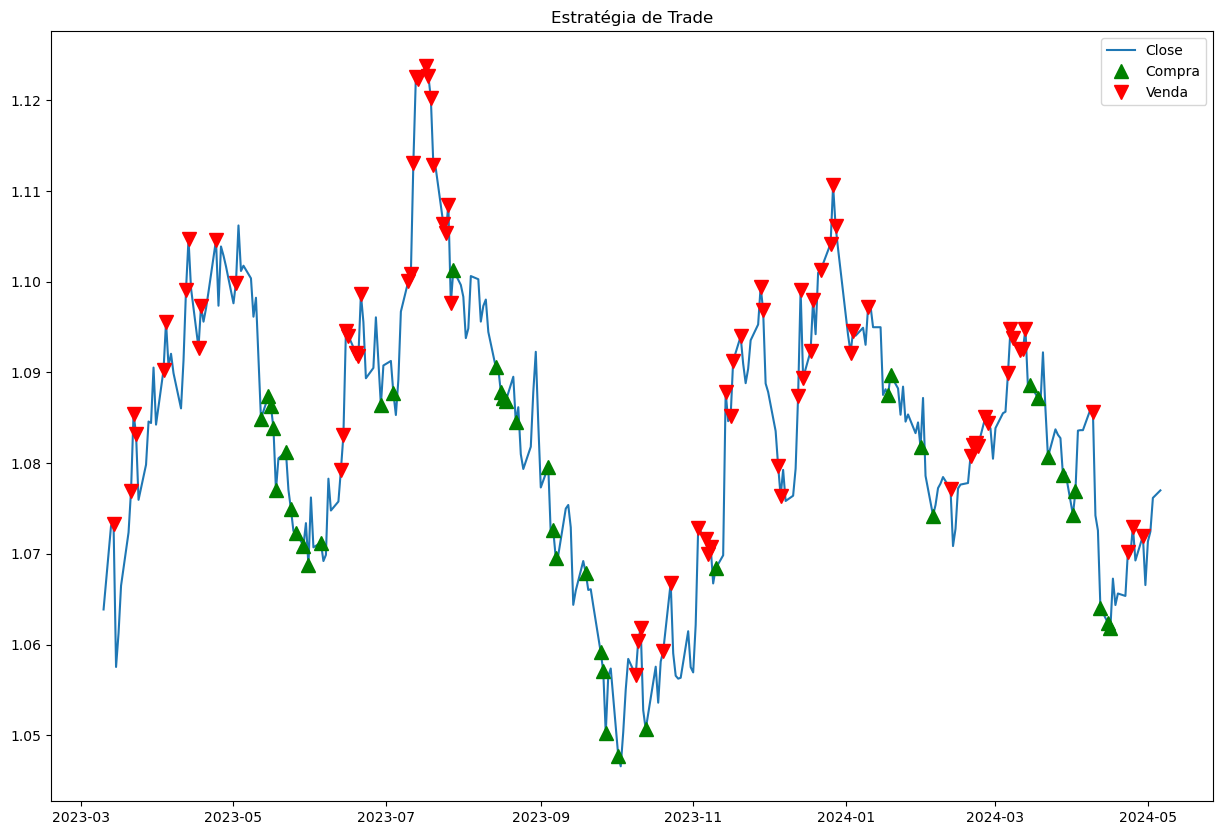

C:\Users\camps pro\AppData\Local\Temp\ipykernel_26520\3755303927.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  g["Retorno10"] = g["Close"].pct_change(3)*100
C:\Users\camps pro\AppData\Local\Temp\ipykernel_26520\3755303927.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  g["Alvo10"] = g["Retorno10"].shift(-3)
C:\Users\camps pro\AppData\Local\Temp\ipykernel_26520\3755303927.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performa

retorno 79.98471777562038
acerto 388
erro 258
acuracia 0.6006191950464397
total de trades 646
total de dias 1549
retorno acumulado em % 79.98471777562041
retorno medio do acerto 0.051636357505242335
retorno medio do erro -0.5815575140072596
retorno medio do acerto 0.5943838666395178
stop loss recomendado de: - 0.5768224156809616
Fique de fora


C:\Users\camps pro\AppData\Local\Temp\ipykernel_26520\3755303927.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('retorno acumulado em %', g['retorno_acumulado'][-3])


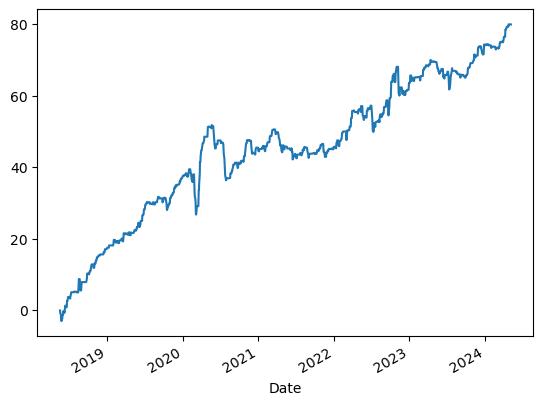

In [5]:
g['decisao'] = np.where(((g['rede'] == 1) & (g['rsi'] < 30)) | ((g['rede'] == 1) & (g['dis_euc_sinal'] == 1)), 1,
                        np.where(((g['rede'] == 0) & (g['rsi'] > 70)) | ((g['rede'] == 0) & (g['dis_euc_sinal'] == -1)), -1, 0))



#plotar um grafico das posicoes
plt.figure(figsize=(15,10))
plt.plot(g['Close'].iloc[-300:], label='Close')
plt.plot(g['Close'].iloc[-300:][g['decisao'] == 1].iloc[-300:], '^', markersize=10, color='g', lw=0, label='Compra')
plt.plot(g['Close'].iloc[-300:][g['decisao'] == -1].iloc[-300:], 'v', markersize=10, color='r', lw=0, label='Venda')
plt.title('Estratégia de Trade')
plt.legend()
#sublinhar o que é compra e o que é venda por um periodo de 3 dias apos o sinal

plt.show()
g["Retorno10"] = g["Close"].pct_change(3)*100
g["Alvo10"] = g["Retorno10"].shift(-3)
g['alvo_bin'] = np.where(g['Alvo10'] > 0, 1, 0)   
g['retorno'] = np.where(g['decisao'] == 1, g['Alvo10'], np.where(g['decisao'] == -1, -g['Alvo10'], 0))
#meta['retorno'] = np.where(meta['retorno'] <= -1, -1, meta['retorno'])
g['retorno_acumulado'] = g['retorno'].cumsum()
g['retorno_acumulado'].plot()

acerto = 0
erro = 0
for i in range(len(g)):
    if (g['decisao'][i] == 1) & (g['alvo_bin'][i] == 1):
        acerto +=1
    elif (g['decisao'][i] == -1) & (g['alvo_bin'][i] == 0):
        acerto +=1
    elif (g['decisao'][i] == 1) & (g['alvo_bin'][i] == 0):
        erro +=1
    elif (g['decisao'][i] == -1) & (g['alvo_bin'][i] == 1):
        erro +=1
print('retorno', g['retorno'].sum())
print('acerto', acerto)
print('erro', erro)
print('acuracia', acerto/(acerto+erro))
print('total de trades', acerto+erro)
print('total de dias' , len(g))
print('retorno acumulado em %', g['retorno_acumulado'][-3])
print('retorno medio do acerto',  g['retorno'].mean())
print('retorno medio do erro',  g['retorno'][g['retorno'] < 0].mean())
print('retorno medio do acerto',  g['retorno'][g['retorno'] > 0].mean())
print('stop loss recomendado de: -', g['Retorno10'].rolling(60).std().tail(1).values[0] )
if g['decisao'].iloc[-1] == 1:
    print('Compre')
elif g['decisao'].iloc[-1] == -1:
    print('Venda')
else:
    print('Fique de fora')

In [6]:
g

,Open,High,Low,Close,Retorno,RSL5,RSL5q,RSL20,delta,gain,...,curva3_cat,cluster_curvas,cluster,rede,decisao,Retorno10,Alvo10,alvo_bin,retorno,retorno_acumulado
Date,,,,,,,,,,,,,,,,,,,,,
2018-05-17,1.18042,1.18374,1.17765,1.17936,-0.001101,-0.005642,0.0,-0.016954,-0.00130,0.00000,...,3,14,11,1,1,NaN,-0.133123,0,-0.133123,-0.133123
2018-05-18,1.17905,1.18221,1.17499,1.17704,-0.001967,-0.004769,1.0,-0.016769,-0.00232,0.00000,...,9,14,11,1,1,NaN,-0.641440,0,-0.641440,-0.774563
2018-05-21,1.17715,1.17953,1.17167,1.17912,0.001767,-0.000731,3.0,-0.013314,0.00208,0.00208,...,6,14,11,1,1,NaN,-0.607233,0,-0.607233,-1.381795
2018-05-22,1.17889,1.18295,1.17569,1.17779,-0.001128,-0.000852,3.0,-0.012552,-0.00133,0.00000,...,6,14,11,1,1,-0.133123,-1.102913,0,-1.102913,-2.484708
2018-05-23,1.17751,1.17895,1.16759,1.16949,-0.007047,-0.006009,0.0,-0.017595,-0.00830,0.00000,...,9,14,11,1,1,-0.641440,-0.607102,0,-0.607102,-3.091810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-30,1.07194,1.07355,1.06647,1.06656,-0.005056,-0.003349,1.0,-0.005126,-0.00542,0.00000,...,2,14,15,1,0,-0.599260,0.901028,1,0.000000,79.984718
2024-05-01,1.06641,1.07328,1.06495,1.07136,0.004500,0.000867,4.0,-0.000078,0.00480,0.00480,...,13,14,7,1,0,0.195460,0.526434,1,0.000000,79.984718
2024-05-02,1.07062,1.07303,1.06743,1.07246,0.001027,0.001994,4.0,0.001471,0.00110,0.00110,...,0,14,7,1,0,0.044777,NaN,0,0.000000,79.984718
